# Cyclist Training






## Introduction

Pour commencer, récupérez les images de la base de données :


In [1]:
!git clone https://github.com/Kizyow/cyclist-ai-training.git

Cloning into 'cyclist-ai-training'...
remote: Enumerating objects: 3156, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 3156 (delta 30), reused 125 (delta 14), pack-reused 3014 (from 4)
Receiving objects: 100% (3156/3156), 824.43 MiB | 17.44 MiB/s, done.
Resolving deltas: 100% (93/93), done.


La base de données qui vous est fournie regroupe 4 classes :

1. Vélos seuls
2. Cycliste portant un casque
3. Cycliste ne portant pas de casque
4. Rien

In [2]:
import PIL
from PIL import Image
import csv
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam


## Préparation des données

Le code ci-dessous permet de charger les données et les formater pour la classification. Prenez le temps de regarder un peu le format des labels $y$.
Notez que les images sont rendues carrées lors du chargement.


Class labels: ['velo_personne_casque', 'velo_personne', 'rien', 'velo']
Ensemble d'entraînement : {'image-454.jpg': [[53.0, 11.0, 253.0, 255.0, 'velo_personne_casque']], 'image-612.jpg': [[93.0, 75.0, 149.0, 208.0, 'velo_personne'], [194.0, 73.0, 251.0, 204.0, 'velo_personne']], 'image-497.jpg': [[61.0, 118.0, 149.0, 250.0, 'velo_personne_casque'], [165.0, 104.0, 244.0, 236.0, 'velo_personne_casque']], 'image-1096.jpg': [[137.0, 40.0, 216.0, 213.0, 'velo'], [82.0, 48.0, 162.0, 211.0, 'velo'], [31.0, 43.0, 111.0, 210.0, 'velo']], 'image-413.jpg': [[39.0, 71.0, 168.0, 255.0, 'velo_personne_casque']], 'image-1004.jpg': [[23.0, 40.0, 180.0, 199.0, 'velo']], 'image-474.jpg': [[119.0, 28.0, 252.0, 252.0, 'velo_personne_casque']], 'image-733.jpg': [[134.0, 11.0, 228.0, 256.0, 'velo_personne']], 'image-936.jpg': [[20.0, 20.0, 117.0, 180.0, 'velo'], [94.0, 28.0, 176.0, 197.0, 'velo'], [170.0, 28.0, 235.0, 208.0, 'velo']], 'image-632.jpg': [[3.0, 77.0, 140.0, 228.0, 'velo_personne']], 'image-92

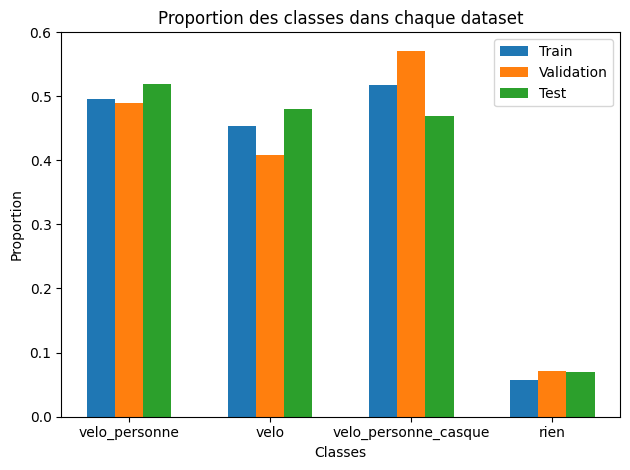

In [39]:
# Pour générer un dataset avec un ensemble d'entrainement, de tests et de validation

import csv
from collections import defaultdict
import random

# Dictionary to store attributes for each filename
image_attributes = defaultdict(list)

# Read the CSV file
with open('cyclist-ai-training/annotations_formatted.csv', newline='') as csvfile:
    filereader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    for row in filereader:
        data = row[0].split(',')
        if data[0] != 'filename':
            filename = data[0]
            xmin = float(data[1])
            ymin = float(data[2])
            width = float(data[3])
            height = float(data[4])
            xmax = xmin + width
            ymax = ymin + height
            attributes = [
                xmin,  # x
                ymin,  # y
                xmax,  # width
                ymax,  # height
                data[5]          # classe
            ]
            image_attributes[filename].append(attributes)

# Number of classes in the dataset and their labels
class_labels = list(dict.fromkeys([attr[4] for attributes_list in image_attributes.values() for attr in attributes_list]))
num_classes = len(class_labels)

print("\nClass labels:", class_labels)

# Calculer le nombre total d'images
total_images = len(image_attributes)

# Calculer le nombre d'images pour chaque ensemble
train_size = int(0.8 * total_images)
val_size = test_size = int(0.10 * total_images)

# Créer des listes pour stocker les images de chaque ensemble
train_images = []
val_images = []
test_images = []

# Mélanger les images pour une distribution aléatoire
all_images = list(image_attributes.keys())
random.seed(23)
random.shuffle(all_images)

# Remplir les ensembles
train_images = all_images[:train_size]
val_images = all_images[train_size:train_size + val_size]
test_images = all_images[train_size + val_size:]

# Créer les ensembles de données
train_set = {img: image_attributes[img] for img in train_images}
val_set = {img: image_attributes[img] for img in val_images}
test_set = {img: image_attributes[img] for img in test_images}

# Afficher les résultats
print("Ensemble d'entraînement :", train_set)
print("Ensemble de validation :", val_set)
print("Ensemble de test :", test_set)

from collections import Counter

# Fonction pour compter les classes dans un ensemble de données
def count_classes(dataset):
    class_counts = Counter()
    for image, boxes in dataset.items():
        for box in boxes:
            class_counts[box[-1]] += 1
    return class_counts

# Compter les classes dans chaque ensemble
train_class_distribution = count_classes(train_set)
val_class_distribution = count_classes(val_set)
test_class_distribution = count_classes(test_set)

# Afficher les distributions
print("Distribution des classes dans l'ensemble d'entraînement :", train_class_distribution)
print("Distribution des classes dans l'ensemble de validation :", val_class_distribution)
print("Distribution des classes dans l'ensemble de test :", test_class_distribution)

import csv

# Fonction pour convertir un ensemble de données en liste de dictionnaires
def dataset_to_csv_format(dataset, dataset_name):
    csv_data = []
    for filename, boxes in dataset.items():
        for box in boxes:
            csv_data.append({
                'filename': filename,
                'dataset': dataset_name,
                'x': box[0],
                'y': box[1],
                'width': box[2],
                'height': box[3],
                'classe': box[4]
            })
    return csv_data

# Convertir chaque ensemble de données
train_csv_data = dataset_to_csv_format(train_set, 'train')
val_csv_data = dataset_to_csv_format(val_set, 'val')
test_csv_data = dataset_to_csv_format(test_set, 'test')

# Fusionner toutes les données
all_csv_data = train_csv_data + val_csv_data + test_csv_data

# Écrire dans un fichier CSV
csv_filename = 'annotations_dispatched.csv'
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=['filename', 'dataset', 'x', 'y', 'width', 'height', 'classe'])
    writer.writeheader()
    writer.writerows(all_csv_data)

print(f"Données exportées avec succès dans {csv_filename}")

import matplotlib.pyplot as plt
import numpy as np

# Fonction pour calculer les proportions des classes dans un ensemble de données
def calculate_proportions(class_counts, total_images):
    return {cls: count / total_images for cls, count in class_counts.items()}

# Calculer les proportions pour chaque ensemble
train_proportions = calculate_proportions(train_class_distribution, len(train_images))
val_proportions = calculate_proportions(val_class_distribution, len(val_images))
test_proportions = calculate_proportions(test_class_distribution, len(test_images))

# Obtenir toutes les classes uniques
all_classes = set(train_class_distribution.keys()).union(val_class_distribution.keys()).union(test_class_distribution.keys())

# Créer un histogramme
fig, ax = plt.subplots()
bar_width = 0.2
index = np.arange(len(all_classes))

# Créer des barres pour chaque ensemble de données
bars_train = ax.bar(index, [train_proportions.get(cls, 0) for cls in all_classes], bar_width, label='Train')
bars_val = ax.bar(index + bar_width, [val_proportions.get(cls, 0) for cls in all_classes], bar_width, label='Validation')
bars_test = ax.bar(index + 2 * bar_width, [test_proportions.get(cls, 0) for cls in all_classes], bar_width, label='Test')

# Ajouter des étiquettes et un titre
ax.set_xlabel('Classes')
ax.set_ylabel('Proportion')
ax.set_title('Proportion des classes dans chaque dataset')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(all_classes)
ax.legend()

# Afficher l'histogramme
plt.tight_layout()
plt.show()

In [3]:
# Lecture du CSV contenant les informations relatives à la base de données
dataset = []
with open('cyclist-ai-training/annotations_dispatched.csv', newline='') as csvfile:
	filereader = csv.reader(csvfile, delimiter=' ', quotechar='|')
	for row in filereader:
		data = row[0].split(',')
		if data[0] != 'filename':
			xmin = float(data[2])
			ymin = float(data[3])
			xmax = float(data[4])
			ymax = float(data[5])
			size = float(256)
			box = [xmin, ymin, xmax, ymax]
			new_entry = {'type': data[1],'class': data[6], 'path': data[0], 'shape': [size, size], 'box': box}
			dataset.append(new_entry)

# Nombre de classes de la base de données et intitulé des classes
class_labels = list(dict.fromkeys([item['class'] for item in dataset]))
num_classes = len(class_labels)

dataset_train = [item for item in dataset if item['type']=='train']
dataset_test = [item for item in dataset if item['type']=='test']
dataset_val = [item for item in dataset if item['type']=='val']

print(class_labels)

['velo_personne_casque', 'velo_personne', 'velo', 'rien']


In [5]:
def build_localization_tensors(image_size, dataset, num_classes):
  # Préparation des structures de données pour x et y
  x = np.zeros((len(dataset), image_size, image_size, 3))
  y = np.empty((len(dataset), num_classes + 5)) # 1 + 4 + num_classes : présence / boîte englobante / classes

  # Compteur de parcours du dataset
  i = 0

  for item in dataset:
    # Lecture de l'image
    img = Image.open('cyclist-ai-training/images/' + item['path'])
    # Mise à l'échelle de l'image
    img = img.resize((image_size,image_size), Image.Resampling.LANCZOS)
    img = img.convert('RGB')
    # Remplissage de la variable x
    x[i] = np.asarray(img)

    y[i, 0] = 1 # Un objet est toujours présent !

    # Coordonnées de boîte englobante
    img_shape = item['shape']
    box = item['box']
    bx = (box[0] + (box[2] - box[0])/2)/img_shape[0]
    by = (box[1] + (box[3] - box[1])/2)/img_shape[1]
    bw = (box[2] - box[0])/img_shape[0]
    bh = (box[3] - box[1])/img_shape[1]
    y[i, 1] = bx
    y[i, 2] = by
    y[i, 3] = bw
    y[i, 4] = bh

    # Probabilités de classe, sous la forme d'une one-hot vector
    label = class_labels.index(item['class'])
    classes_probabilities = keras.utils.to_categorical(label, num_classes=num_classes)
    y[i, 5:] = classes_probabilities

    i = i+1

  return x, y


Séparation des données d'entraînement pour extraire un ensemble de validation, et pré-traitement des données.

In [6]:
# Pour la suite du TP on considèrera des images de taille 64x64x3
# Augmenter cette valeur donnerait de meilleurs résultats mais nécessiterait des calculs plus long.
IMAGE_SIZE = 128

# Lecture des données d'entraînement, de tests et de validations
x_train, y_train = build_localization_tensors(IMAGE_SIZE, dataset_train, num_classes)
x_test, y_test = build_localization_tensors(IMAGE_SIZE, dataset_test, num_classes)
x_val, y_val = build_localization_tensors(IMAGE_SIZE, dataset_val, num_classes)

# Pour améliorer l'entraînement, on peut centrer-réduire les coordonnées des bounding boxes...
y_std = np.std(y_train, axis=0)
y_mean = np.mean(y_train, axis=0)
y_train[...,1:5] = (y_train[...,1:5] - y_mean[1:5])/y_std[1:5]
y_val[...,1:5] = (y_val[...,1:5] - y_mean[1:5])/y_std[1:5]
y_test[...,1:5] = (y_test[...,1:5] - y_mean[1:5])/y_std[1:5]

# ... et normaliser les valeurs de couleur
x_train = x_train/255
x_val = x_val/255
x_test = x_test/255

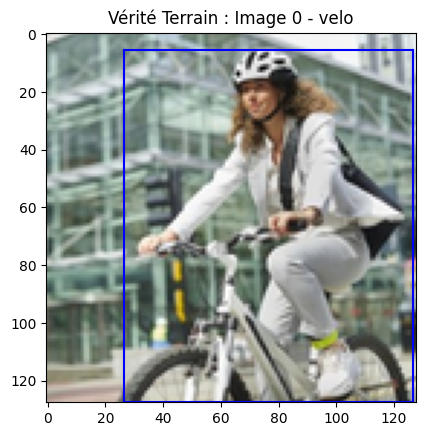

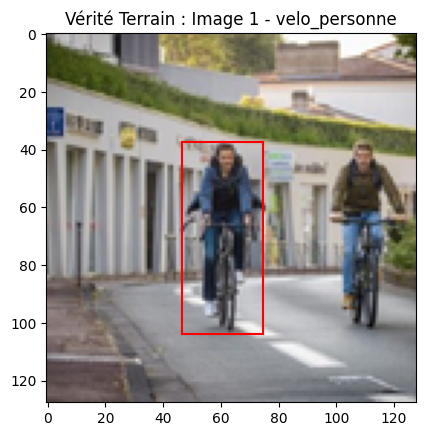

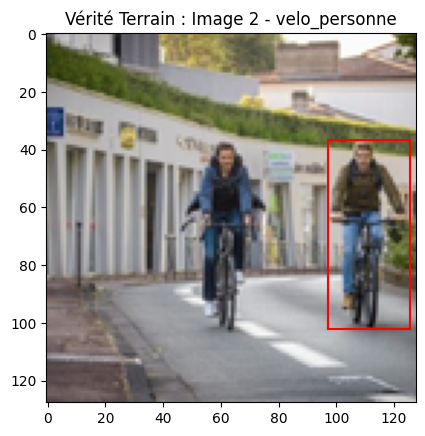

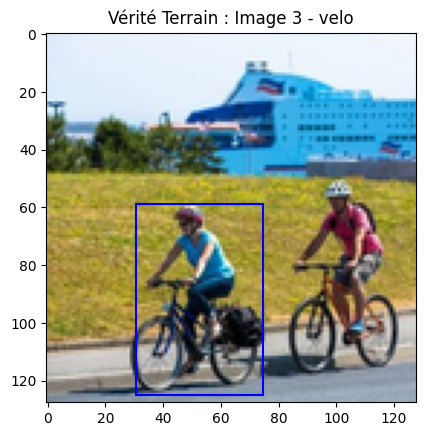

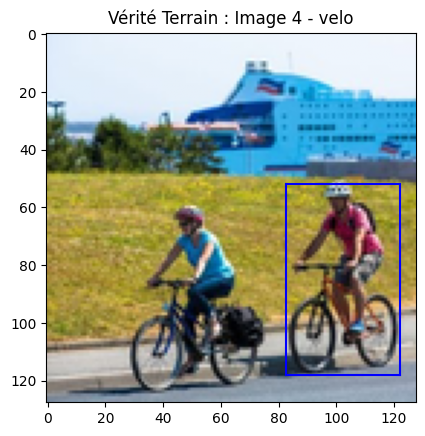

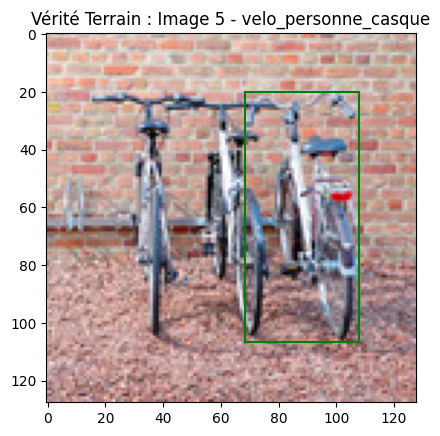

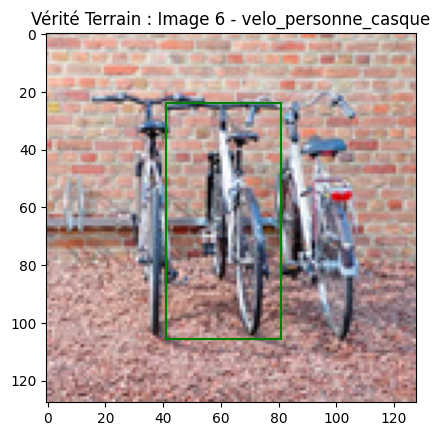

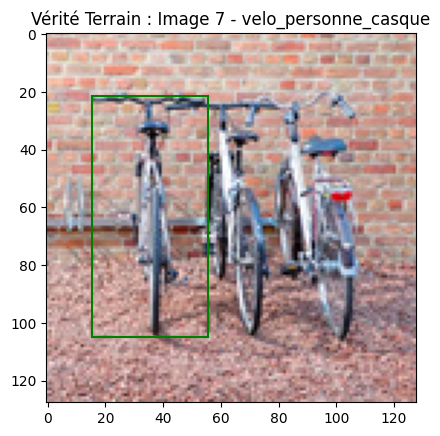

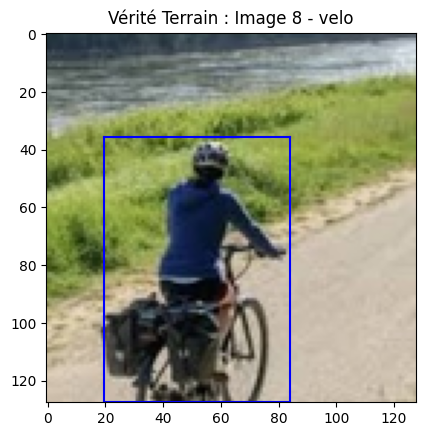

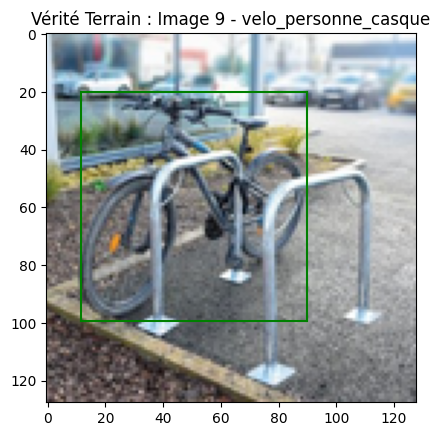

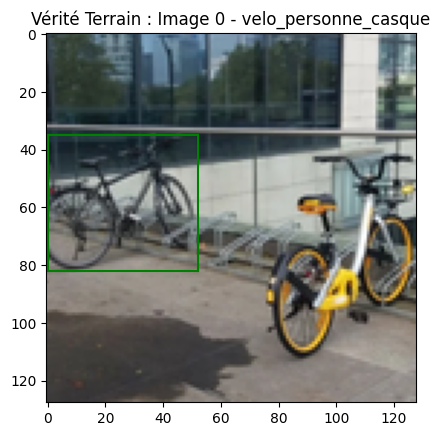

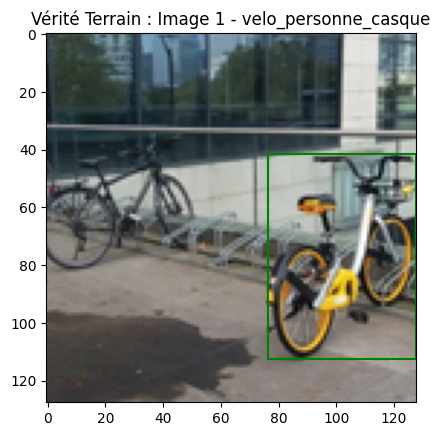

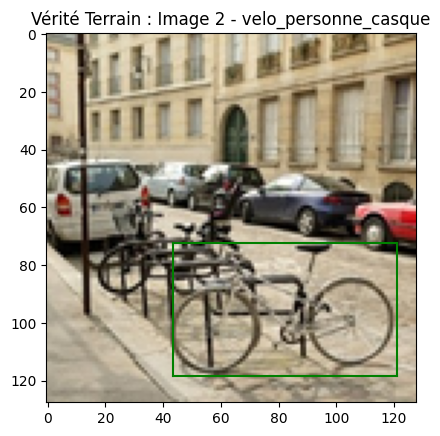

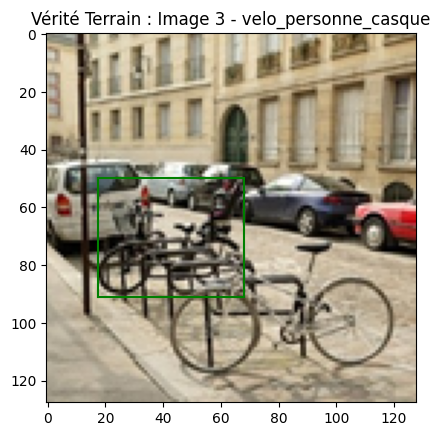

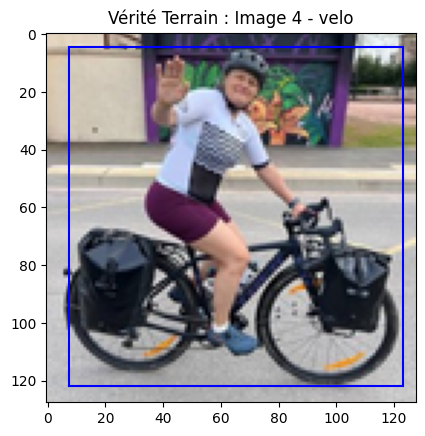

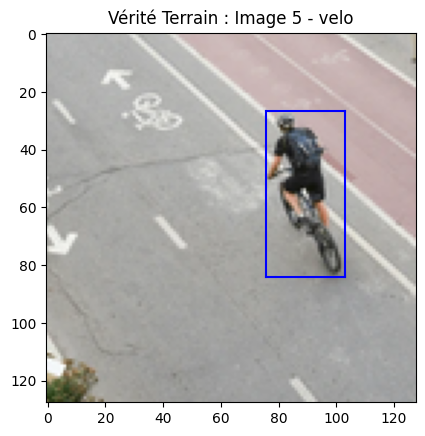

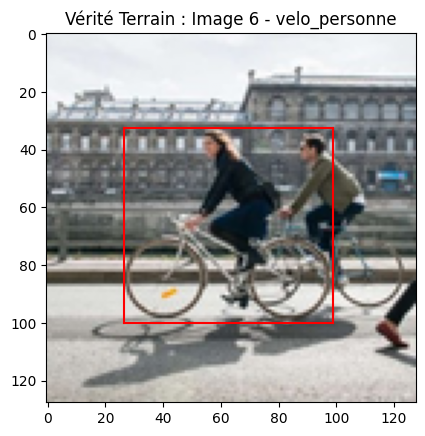

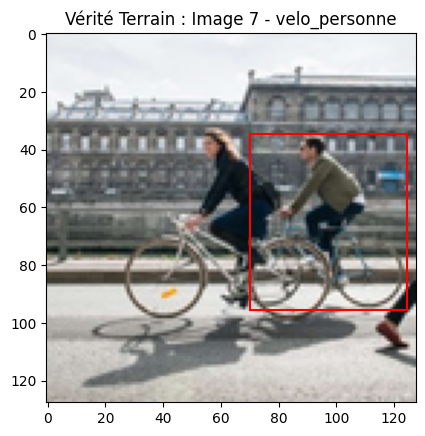

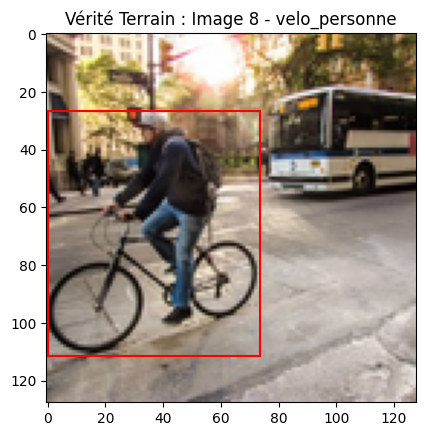

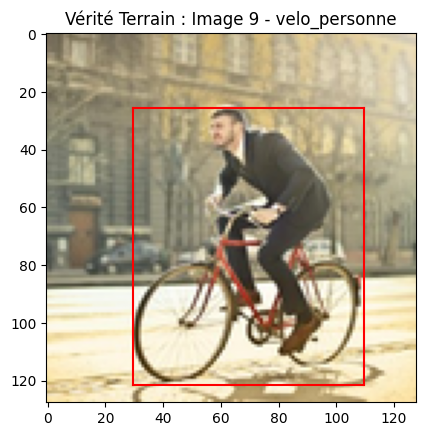

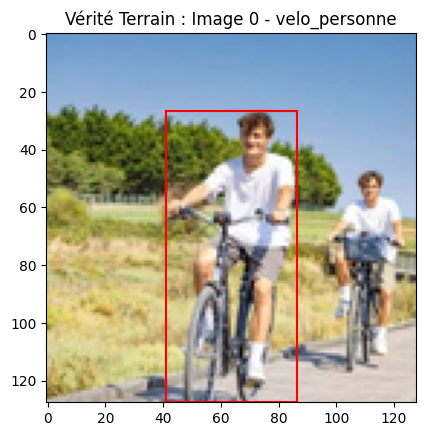

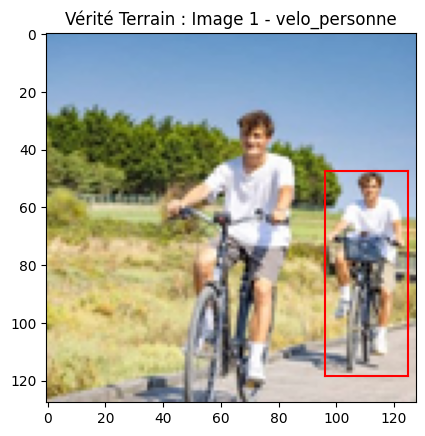

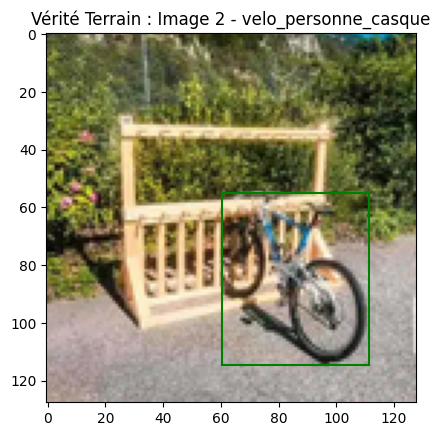

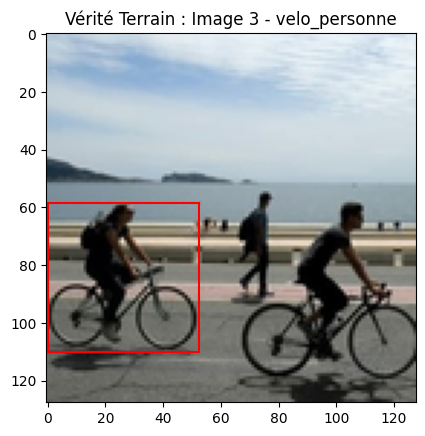

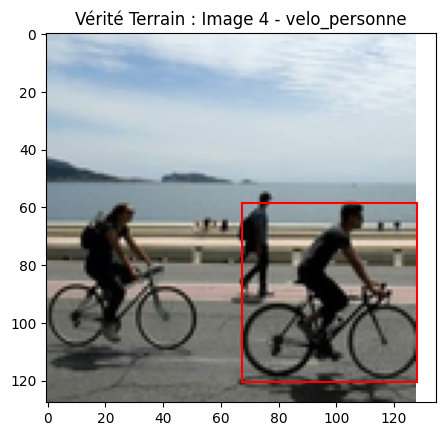

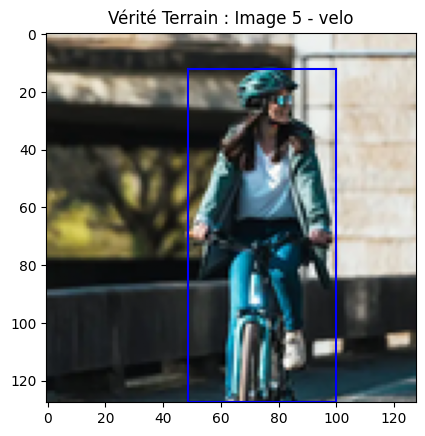

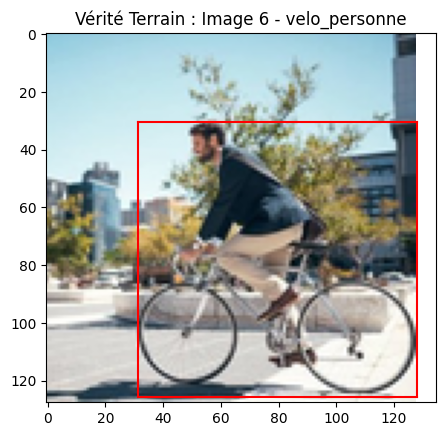

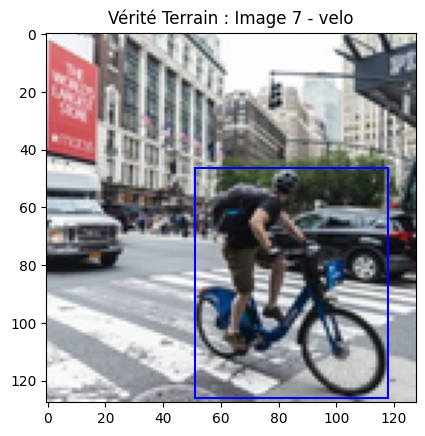

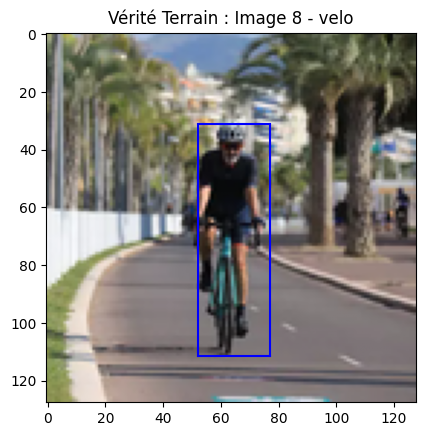

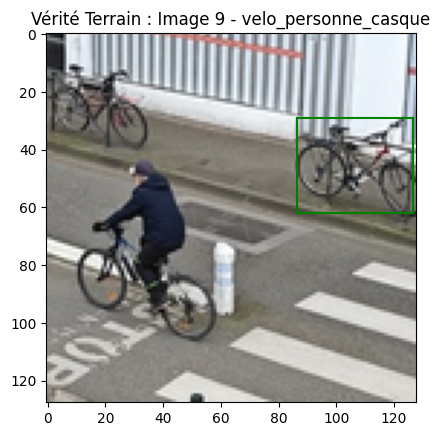

In [9]:
# Si seuls x et y sont indiqués, on tire au hasard un numéro d'image et on affiche le label y associé  à l'image
# Si un 2e y, nommé y_pred, est indiqué, alors les deux labels sont affichés côte à côte, afin de pouvoir les comparer
# Enfin on peut également indiquer l'id de l'image que l'on souhaite visualiser.
def print_data_localisation(x, y, y_pred=[], id=None, image_size=64):
  if id==None:
    # Tirage aléatoire d'une image dans la base
    num_img = np.random.randint(x.shape[0]-1)
  else:
    num_img = id

  img = x[num_img]
  lab = y[num_img]

  colors = ["blue", "red", "green", "yellow"] # Différentes couleurs pour les différentes classes
  classes = ['velo', 'velo_personne', 'velo_personne_casque', 'rien']

  if np.any(y_pred):
    plt.subplot(1, 2, 1)

  # Affichage de l'image
  plt.imshow(img)
  # Détermination de la classe
  class_id = np.argmax(lab[5:])

  # Détermination des coordonnées de la boîte englobante dans le repère image
  ax = (lab[1]*y_std[1] + y_mean[1]) * image_size
  ay = (lab[2]*y_std[2] + y_mean[2]) * image_size
  width = (lab[3]*y_std[3] + y_mean[3]) * image_size
  height = (lab[4]*y_std[4] + y_mean[4]) * image_size
  #print("x: {}, y: {}, w: {}, h:{}".format(ax,ay,width, height))
  # Détermination des extrema de la boîte englobante
  p_x = [ax-width/2, ax+width/2]
  p_y = [ay-height/2, ay+height/2]
  # Affichage de la boîte englobante, dans la bonne couleur
  plt.plot([p_x[0], p_x[0]],p_y,color=colors[class_id])
  plt.plot([p_x[1], p_x[1]],p_y,color=colors[class_id])
  plt.plot(p_x,[p_y[0],p_y[0]],color=colors[class_id])
  plt.plot(p_x,[p_y[1],p_y[1]],color=colors[class_id])
  plt.title("Vérité Terrain : Image {} - {}".format(num_img, classes[class_id]))

  if np.any(y_pred):
    plt.subplot(1, 2, 2)
    # Affichage de l'image
    plt.imshow(img)
    lab = y_pred[num_img]
    # Détermination de la classe
    class_id = np.argmax(lab[5:])

    # Détermination des coordonnées de la boîte englobante dans le repère image
    ax = (lab[1]*y_std[1] + y_mean[1]) * image_size
    ay = (lab[2]*y_std[2] + y_mean[2]) * image_size
    width = (lab[3]*y_std[3] + y_mean[3]) * image_size
    height = (lab[4]*y_std[4] + y_mean[4]) * image_size
    #print("x: {}, y: {}, w: {}, h:{}".format(ax,ay,width, height))
    # Détermination des extrema de la boîte englobante
    p_x = [ax-width/2, ax+width/2]
    p_y = [ay-height/2, ay+height/2]
    # Affichage de la boîte englobante, dans la bonne couleur
    plt.plot([p_x[0], p_x[0]],p_y,color=colors[class_id])
    plt.plot([p_x[1], p_x[1]],p_y,color=colors[class_id])
    plt.plot(p_x,[p_y[0],p_y[0]],color=colors[class_id])
    plt.plot(p_x,[p_y[1],p_y[1]],color=colors[class_id])
    plt.title("Prédiction : Image {} - {}".format(num_img, classes[class_id]))

  plt.show()

for i in range(10):#x.shape[0]):
    print_data_localisation(x_train, y_train, image_size=IMAGE_SIZE, id=i)
for i in range(10):
    print_data_localisation(x_val, y_val, image_size=IMAGE_SIZE, id=i)
for i in range(10):
    print_data_localisation(x_test, y_test, image_size=IMAGE_SIZE, id=i)
